
# ENSO Recharge Oscillator Practical: Simulations and Forecasting
This notebook is the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). The practical covers theoretical and computational aspects of the RO model, its applications in ENSO simulations, and forecasting.

**Instructors**:
- Sen Zhao <zhaos@hawaii.edu>
- Soong-Ki Kim <sskk503@yonsei.ac.kr>        

**Reviewer**
- Jérôme Vialard

In this notebook, we will demonstrate how to `CRO` library for **Recharge-Oscilattor (RO)** model simulations

## 1 RO equations
$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$

See the details in [Technical Note for the Community Recharge Oscillator (CRO) Model Package](./CRO_Code_Technical_Note_Winter_School_v1.0.pdf).


### Python libraries

Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "climpred", "dateutil", "nc-time-axis", "seaborn",
]

# # Install missing packages if needed
# for pkg in required_packages:
#     install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator

In [120]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# !wget -c https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
# !wget -c https://github.com/senclimate/XRO/raw/main/code/XRO.py

from CRO import RO_BWJ_analysis, RO_fitting, RO_solver
from XRO import XRO, xcorr
from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 2 Observed ENSO properties 

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes 

$X_{ENSO}=[T_{ENSO}, WWV]$ 


### 2.1 ENSO time series

<xarray.Dataset>
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 ...
Data variables:
    Nino34   (time) float32 ...
    WWV      (time) float32 ...


Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

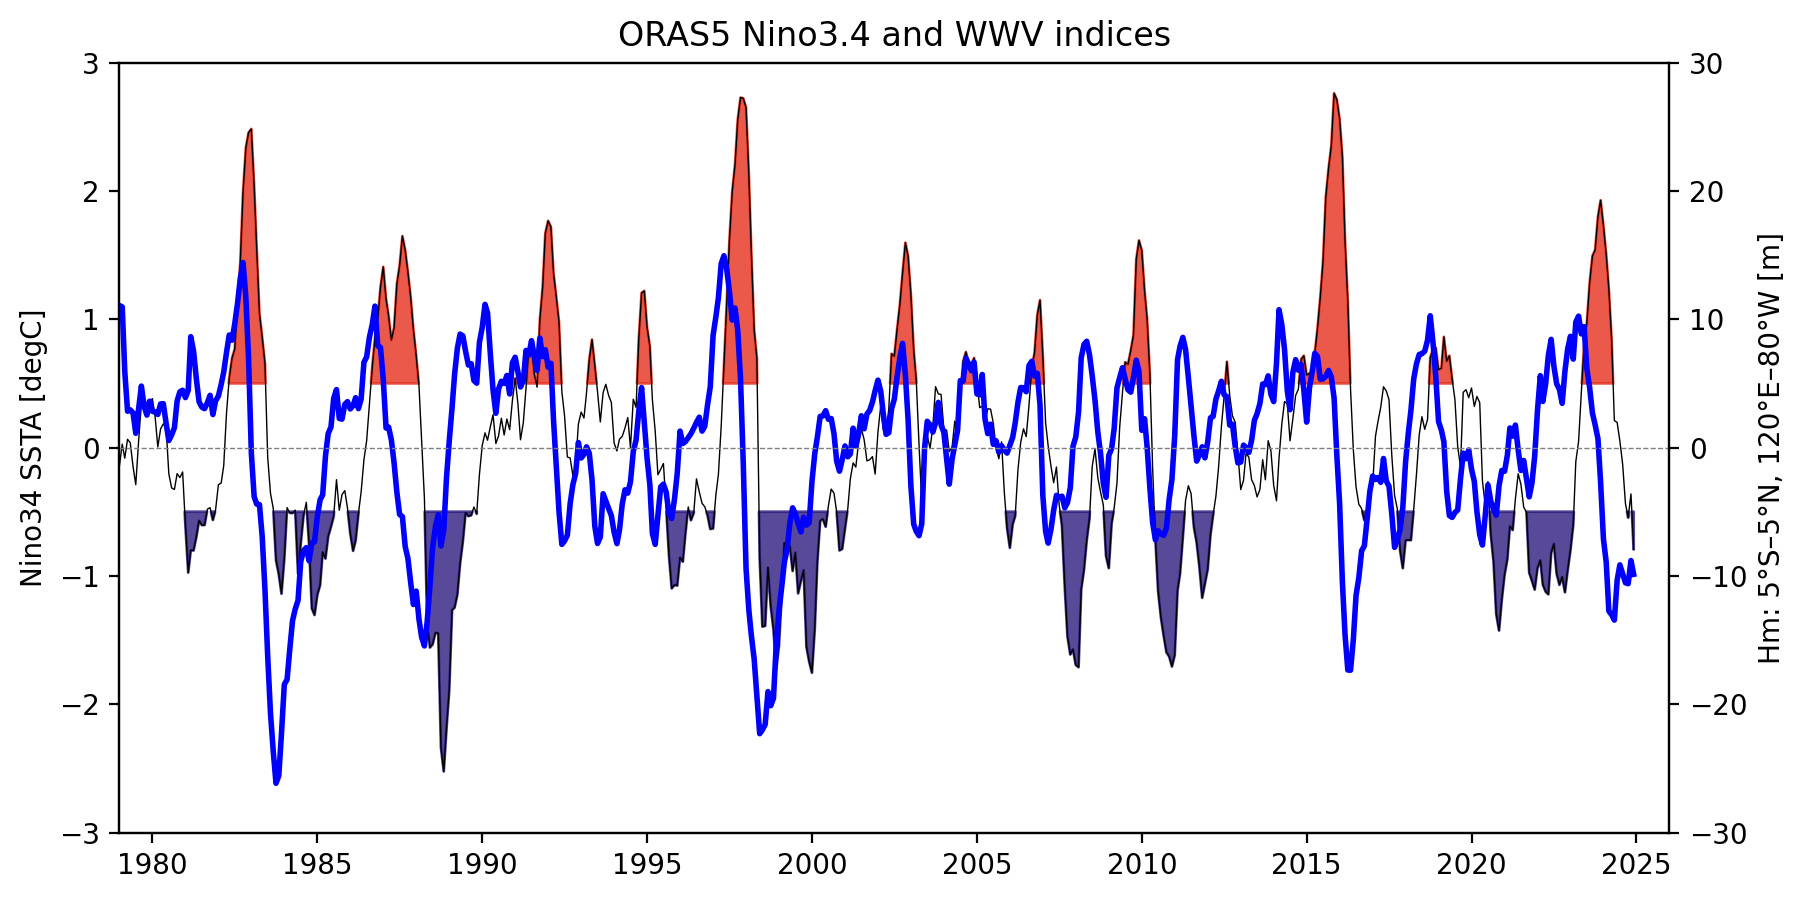

In [121]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/XRO_indices_oras5.nc').sel(time=slice('1979-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
print(obs_RO_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plot_above_below_shading(obs_RO_ds['Nino34'], xtime=obs_RO_ds.time, c='black', lw=0.5, ax=ax)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel('Nino34 SSTA [degC]')

axR = ax.twinx()
obs_RO_ds['WWV'].plot(ax=axR, c='blue', lw=2)
axR.set_ylim([-30, 30])
axR.axhline(0, ls='--', c='gray', lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title('ORAS5 Nino3.4 and WWV indices')

### 2.2 Observed ENSO seasonal synchronization

It can be represented as ENSO SSTA's seasonal variance (or standard deviation)

In [122]:
stddevAC_obs_ds = obs_RO_ds.groupby('time.month').std('time')
print(stddevAC_obs_ds)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Nino34   (month) float64 1.142 0.9521 0.7425 0.5979 ... 1.039 1.195 1.224
    WWV      (month) float64 5.734 6.448 7.07 7.344 ... 7.267 7.673 7.049 6.229


Text(0.5, 1.0, 'ENSO seasonal synchronization')

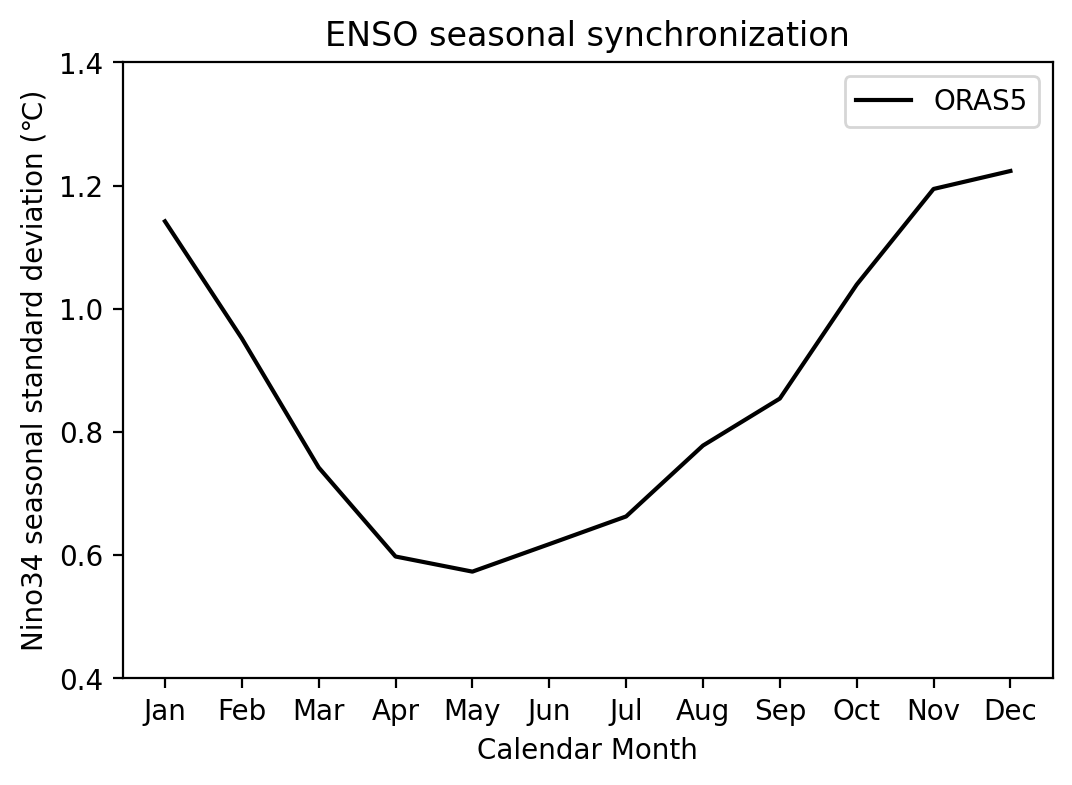

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.4])
plt.title('ENSO seasonal synchronization')

### 2.3 Observed ENSO asymmetry and skewness

- check the function compute_skew in XRO_utils.py
- ENSO's skewness

In [124]:
skew_obs_ds = obs_RO_ds.skew('time')
print(skew_obs_ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    Nino34   float64 0.4996
    WWV      float64 -0.9064


### 2.4 ENSO SST-WWV relationships

In [125]:
ccr_obs_ds = xcorr(obs_RO_ds, obs_RO_ds['Nino34'], maxlags=36)
print(ccr_obs_ds)

<xarray.Dataset>
Dimensions:  (lag: 73)
Coordinates:
  * lag      (lag) int32 -36 -35 -34 -33 -32 -31 -30 ... 30 31 32 33 34 35 36
Data variables:
    Nino34   (lag) float64 0.0004787 0.001371 -0.008197 ... 0.001371 0.0004787
    WWV      (lag) float64 -0.1614 -0.1661 -0.1732 ... 0.2104 0.1919 0.1674


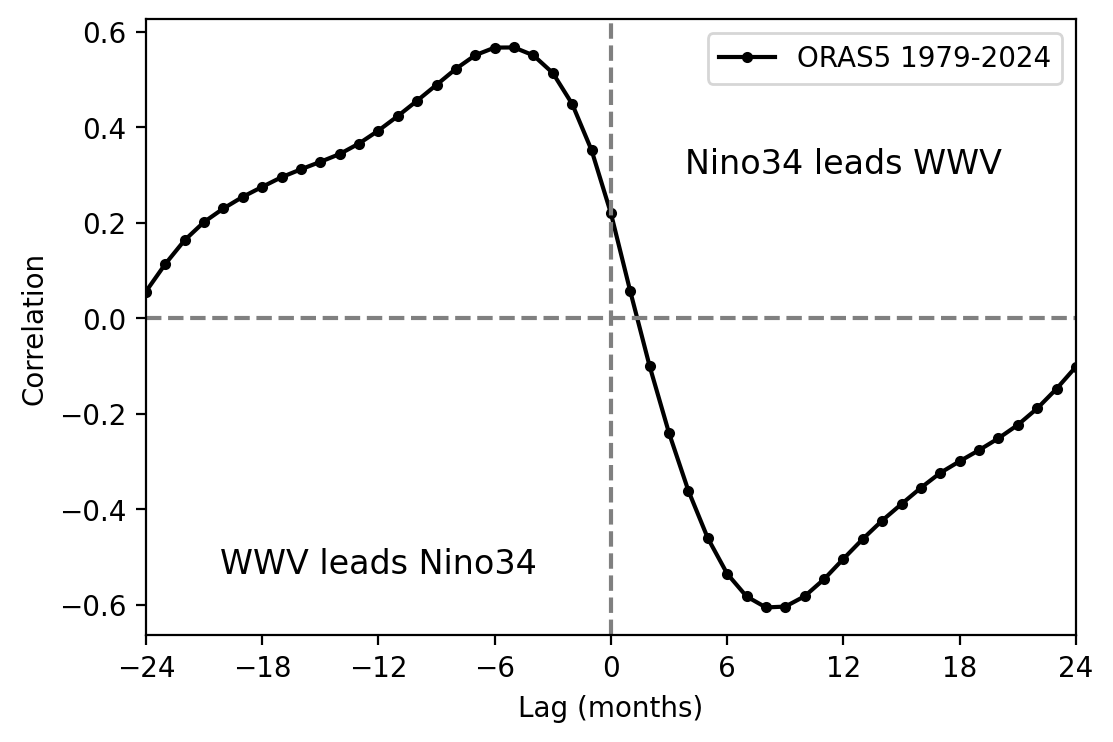

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### decadal shift in ENSO SST-WWV relationship
- McPhaden, M. J. (2012). A 21st century shift in the relationship between ENSO SST and warm water volume anomalies. Geophysical Research Letters, 39(9). https://doi.org/10.1029/2012GL051826

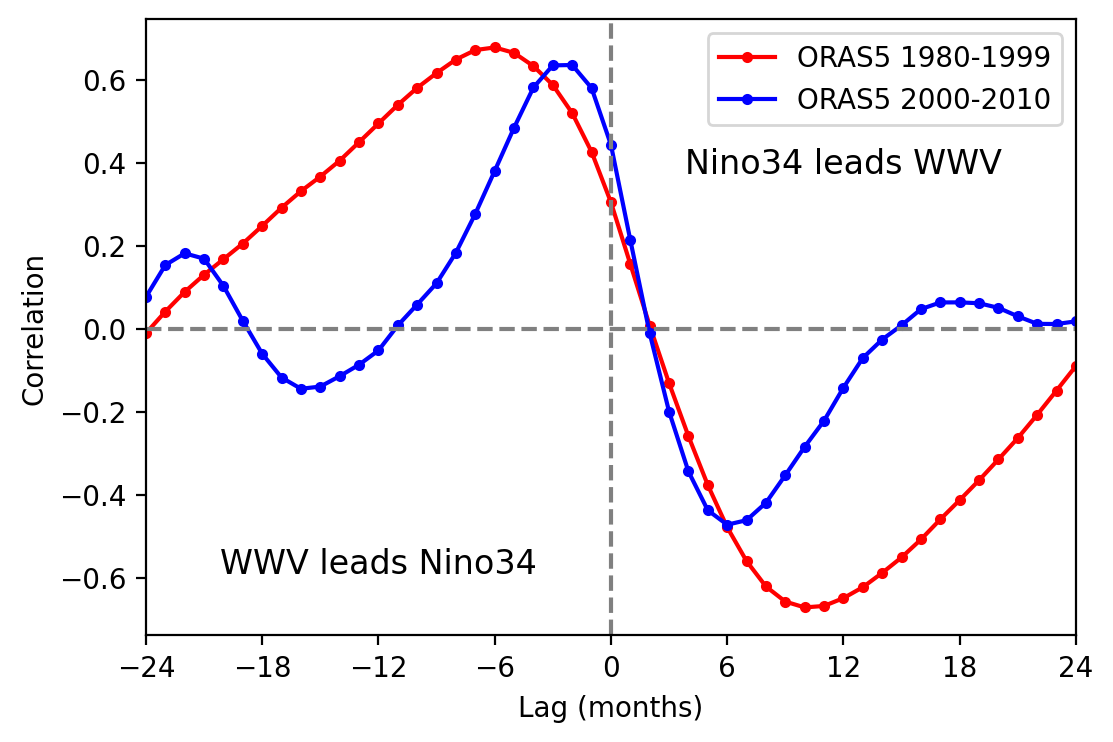

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

slice_P1 = slice('1980-01', '1999-12')
slice_P2 = slice('2000-01', '2010-12')
ccr_obs_P1 = xcorr(obs_RO_ds.sel(time=slice_P1), obs_RO_ds['Nino34'].sel(time=slice_P1), maxlags=36)
ccr_obs_P2 = xcorr(obs_RO_ds.sel(time=slice_P2), obs_RO_ds['Nino34'].sel(time=slice_P2), maxlags=36)

sel_var = 'WWV'
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='red', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

### 2.5 ENSO spectrum analysis

Thomson’s multitaper power spectral density (PSD) estimate
See pmtm in `XRO_utils.py`

**Combination mode**

Stuecker, M. F., Timmermann, A., Jin, F.-F., McGregor, S., & Ren, H.-L. (2013). A combination mode of the annual cycle and the El Niño/Southern Oscillation. Nature Geoscience, 6(7), 540–544. https://doi.org/10.1038/ngeo1826


In [128]:
psd_obs, psd_sig_obs, psd_ci_obs = pmtm( obs_RO_ds['Nino34'], dim='time', dt=1/12, nw=5)
print(psd_obs.coords)

Coordinates:
  * freq     (freq) float64 0.0 0.02174 0.04348 0.06522 ... 5.957 5.978 6.0


Text(0.5, 1.0, 'Spectrum of Niño3.4 SST anomaly')

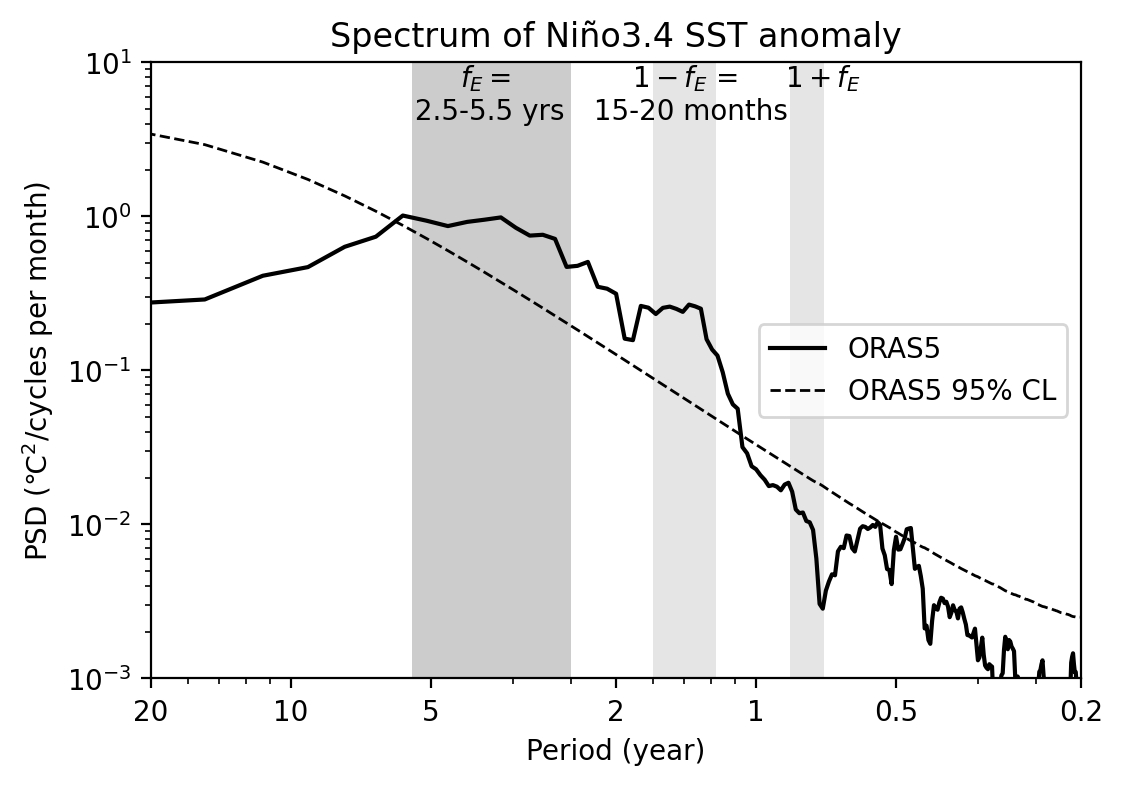

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='right')

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

## 3. RO stochastic simulations with different complexities

### 3.1 Validating whether the fitted RO model reproduces observed properties
We fitted the RO model with observed Nino34 and WWV indices with full complexities

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$


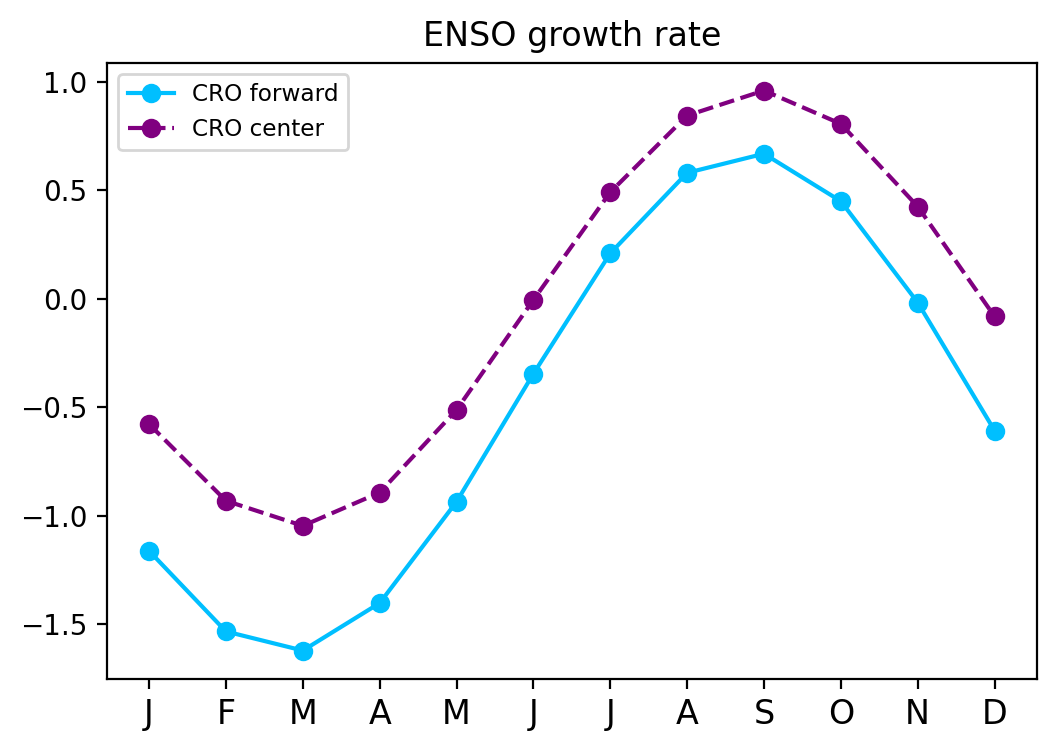

In [148]:
dt_fitting = 1.0 # with monthly input 

#Choose the type of RO to fit with T and h

T_option={'R': 3, 'F1': 3, 'b_T': 0, 'c_T': 0, 'd_T': 0} 
h_option={'F2': 3, 'epsilon': 3, 'b_h': 0}
noise_option_white = {'T': "white", 'h': "white", 'T_type': "additive"} 
noise_option_red  = {'T': "red", 'h': "red", 'T_type': "additive"} 

method_fitting='LR-C'
fit_CRO_para_C = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO_C = RO_BWJ_analysis(fit_CRO_para_C, deriative='C')

method_fitting='LR-F'
fit_CRO_para_F = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO_F = RO_BWJ_analysis(fit_CRO_para_F)



fig, ax=plt.subplots(1, 1, figsize=(6, 4))
xmonth = range(1, 13)

# ax.plot(xmonth, fit_CRO_F['R'], color='deepskyblue', marker='*', label='CRO forward')
# ax.plot(xmonth, fit_CRO_C['R'], color='purple', marker='o', ls='--', label='CRO center')


ax.plot(xmonth, fit_CRO_F['BJ'], color='deepskyblue', marker='.', ms=12, label='CRO forward')
ax.plot(xmonth, fit_CRO_C['BJ'], color='purple', marker='.', ms=12, ls='--', label='CRO center')

# ax.bar(xmonth, fit_CRO['BJ'], color='gray')
# ax.plot(xmonth, fit_XRO_F_ds['BJ_ac'], marker='o', color='red')

ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=12)
ax.set_title('ENSO growth rate')
ax.legend(fontsize='small')

# print(fit_CRO)
# print(fit_XRO_F_ds)

In [163]:
# Call RO_solver with parameters obtained on ORAS5 dataset.
# And generation of NE synthetic timeseries with the fitted parameters 

def RO_simulation(para, B=0, N = 100*12, NE = 100, output_type='snapshot', seed=None, derivative='F'):
    par = para
    par['B'] = B
    IC = obs_ds[['Nino34', 'WWV']].isel(time=0).to_array().values #Initial condition, arbitrary choice here
    # N = 100*12 #Lenght of the time series in month
    # NE = 100 # Number of members to generate
    EF = {'E_T':0.0,'E_h':0.0} #External forcing, null here.
    NM = 'EH' # numerical scheme
    dt = 0.1  # dt used in RO solver in month
    saveat = 1.0 # save every saveat month, needs to be an integer multiple of dt
    # output_type='snapshot' or output_type='monthly_mean'  
    #Call the RO solver function
    #This returns an ensemble of NE members of T,h and the white noises used for integration
    out_ds = RO_solver(par=par,IC=IC,N=N,NE=NE,EF=EF,NM=NM,dt=dt,
                        saveat=saveat,noise_custom=[], output_type=output_type, seed=seed, derivative=derivative)
    time = xr.cftime_range('1900-01', periods=len(out_ds.time), freq='MS')
    out_ds['time'] = time
    return out_ds.rename({'T': 'Nino34', 'h': 'WWV'})

sim_RO_F = RO_simulation(fit_CRO_para_F, B=0, N = 100*12, NE = 100, output_type='snapshot', derivative='F')
sim_RO_C = RO_simulation(fit_CRO_para_C, B=0, N = 100*12, NE = 100, output_type='snapshot', derivative='C')

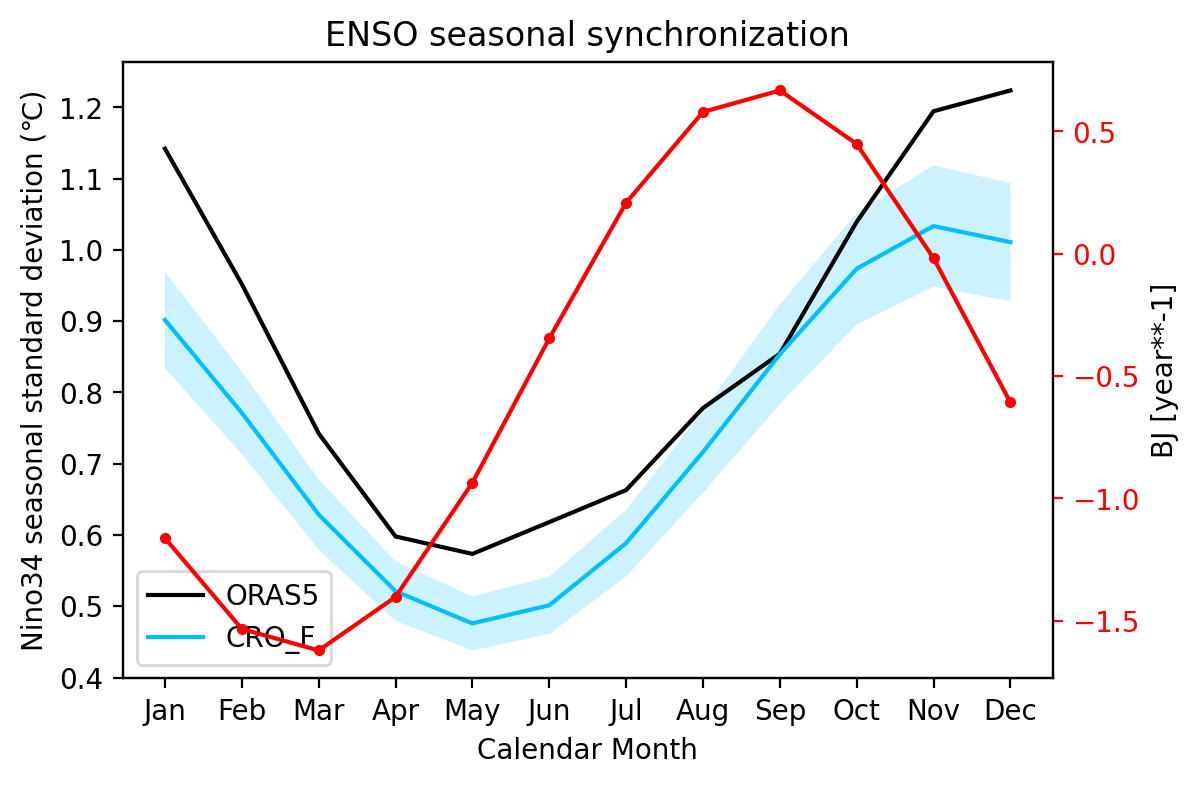

In [176]:
stddevAC_CRO_F_ds = sim_RO_F.groupby('time.month').std('time')
stddevAC_CRO_C_ds = sim_RO_C.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_CRO_F_ds[sel_var], xtime=x_month, ax=ax, c='deepskyblue',  label='CRO_F')
# plot_fill_between(stddevAC_CRO_C_ds[sel_var], xtime=x_month, ax=ax, c='purple',  label='CRO_C')
axR=ax.twinx()
fit_CRO_F['BJ'].plot(c='red', marker='.', ax=axR)
axR.tick_params(axis='y', colors='red', labelcolor='red')
# axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
# ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

In [ ]:
Tend_i = i+1 - i 
Tend_(i+0.5)

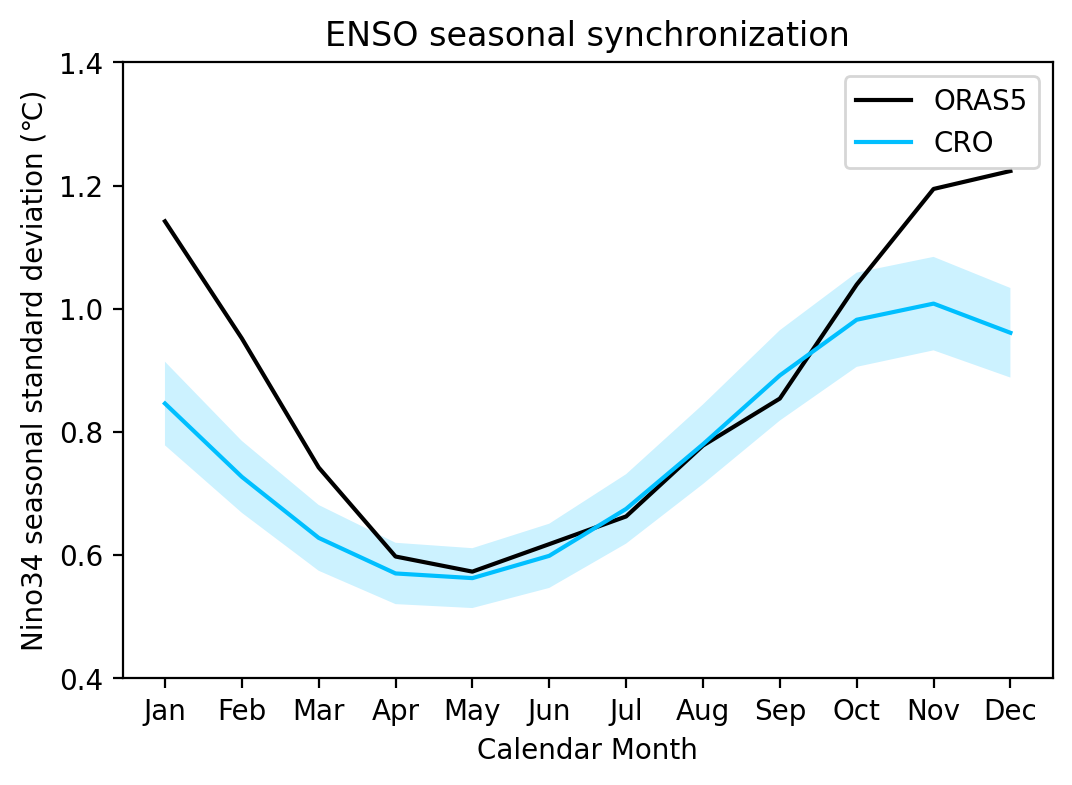

In [170]:
dt_fitting = 1.0 # with monthly input 

#Choose the type of RO to fit with T and h

T_option={'R': 3, 'F1': 1, 'b_T': 1, 'c_T': 1, 'd_T': 1} 
h_option={'F2': 1, 'epsilon': 1, 'b_h': 1}
noise_option_white = {'T': "white", 'h': "white", 'T_type': "additive"} 
noise_option_red  = {'T': "red", 'h': "red", 'T_type': "additive"} 

method_fitting='LR-F'
fit_CRO_para = RO_fitting(T=obs_RO_ds['Nino34'].values,
                          h=obs_RO_ds['WWV'].values,
                          T_option=T_option, 
                          h_option=h_option, 
                          noise_option=noise_option_white, 
                          method_fitting=method_fitting,
                          dt_fitting=1.0,)
fit_CRO = RO_BWJ_analysis(fit_CRO_para)
sim_CRO = RO_simulation(fit_CRO_para, B=0.0, N = 100*12, NE = 100, output_type='snapshot', derivative='F')

stddevAC_CRO_ds = sim_CRO.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_CRO_ds[sel_var], xtime=x_month, ax=ax, c='deepskyblue',  label='CRO')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

The XRO model form : dX/dt = L * X + NRO_T + NRO_H + \xi

NRO_T is nonlinear terms in ENSO's T equation
NRO_H is nonlinear terms is ENSO's H equation

**XRO equation forms**

- The standard XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus `maskb=['IOD']`, `maskNT=['T2', 'TH']`
- The linear form of XRO is setting `maskb=[]` and `maskNT=[]`

Text(0.5, 1.0, 'ENSO seasonal synchronization')

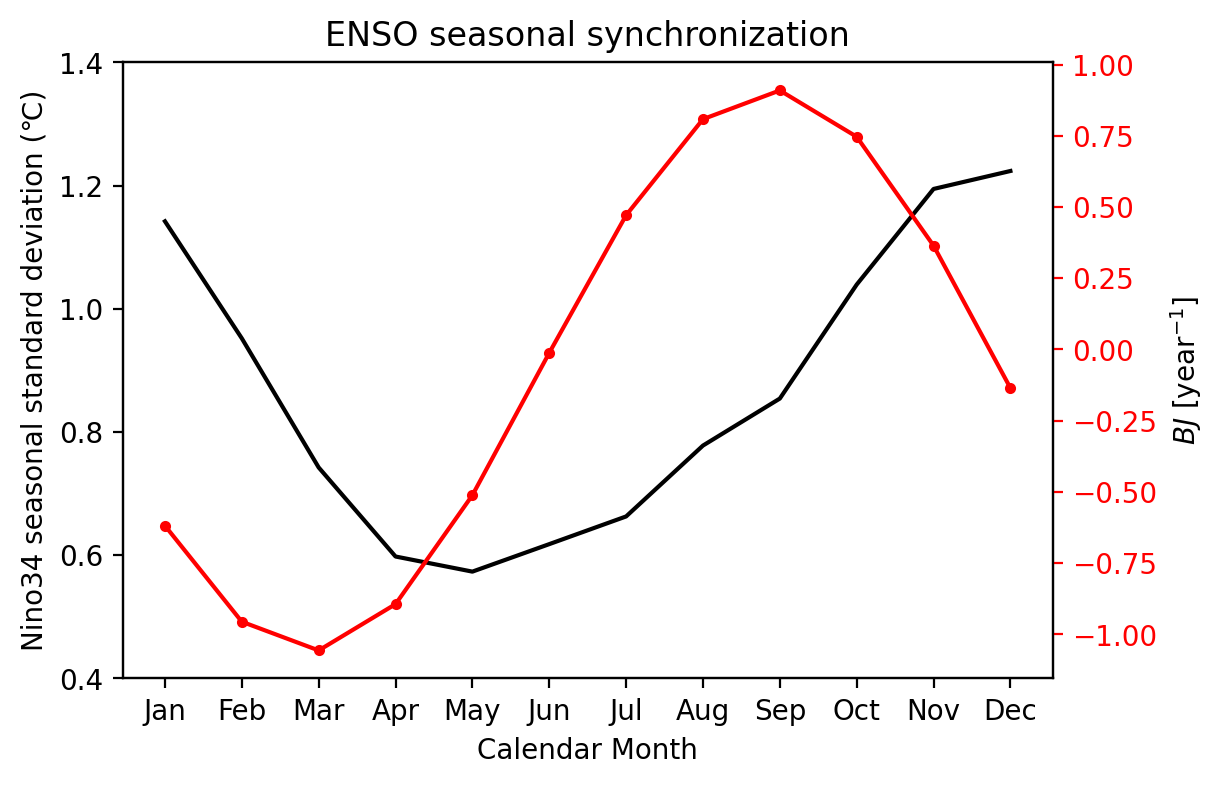

In [136]:
# model with full annual cycle
fit_NRO = XRO_ac2.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
# fit_NRO = XRO_ac2.set_NRO_annualmean(fit_NRO)
fit_NRO_ds = XRO_ac2.get_RO_parameters(fit_NRO)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

axR=ax.twinx()
fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
axR.tick_params(axis='y', colors='red', labelcolor='red')
# axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')

In [ ]:
fit_NRO_ds/12

`XRO_ac2.simulate`

Stochastic simulations (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=False` if consider seasonal modulation of noise amplitde (default is None)

The output is archived as monthly mean of state vectors

In [ ]:
seed = 100
sim_NRO = XRO_ac2.simulate(fit_ds=fit_NRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

#### Reproduce ENSO irregular interannual oscillations
Show the time series of each member

In [ ]:
nmember = 10

ncol = 2
nrow = nmember//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*6, nrow*2), sharey=True, sharex=True, layout='compressed')

for i, ax in enumerate(axes.flat):
    plot_above_below_shading(sim_NRO.isel(member=i*2)['Nino34'], c='black', lw=0.5, ax=ax)
    # ax.set_xlabel('Model years')
    ax.set_xlim([1, 102])
    ax.set_xticks(np.arange(0, 101, step=10))

#### Reproduce the observed ENSO seasonal synchronization

In [ ]:
stddevAC_NRO_ds = sim_NRO.groupby('time.month').std('time')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

#### Reproduce the observed ENSO skewness

In [ ]:
skew_NRO_ds = sim_NRO.skew('time')

sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True, layout='compressed')

bins = np.arange(-2, 2.01, step=0.1)
model_lists = [skew_NRO_ds]
model_labels = ['NRO']

for i, model_ds  in enumerate(model_lists):
    sns.histplot(model_ds[sel_var], stat='density', bins=bins, ax=ax, alpha=0.9, label=model_labels[i])

ax.axvline(skew_obs_ds[sel_var], c='black', lw=2)
ax.set_xlim([-1.5, 1.5])
ax.set_xlabel(f'{sel_var} skewness')
ax.text( skew_obs_ds[sel_var]+0.01, 2., 'ORAS5', rotation=90, fontsize=14)
ax.legend()

#### Reproduce the observed ENSO SST-WWV relationships

In [ ]:
ccr_NRO_ds = xcorr(sim_NRO, sim_NRO['Nino34'], maxlags=36)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'Nino34'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_title('Nino34 autocorrelation')
ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.set_xlim([0, 36])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### Reproduce the observed ENSO spectrum

In [ ]:
psd_NRO, psd_sig_NRO, psd_ci_NRO = pmtm( sim_NRO['Nino34'], dim='time', dt=1/12, nw=5)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

ax.loglog(psd_NRO.freq, psd_NRO.mean('member'), lw=1.5, color='orangered', label='NRO')
ax.fill_between(psd_NRO.freq, psd_NRO.quantile(0.1, dim='member'), 
                psd_NRO.quantile(0.9, dim='member'), fc='orangered', label='NRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_NRO.freq, psd_sig_NRO.mean('member'), color='orangered', linestyle='--', label='NRO 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

### 3.2 ENSO seasonal phase locking & sensitivity to parameters (R’s seasonal cycle)

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), XRO control simulation, and XRO(ac=0) simulation.

- As shown in the figure, XRO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the XRO operators, there is no seasonal synchronization (blue curve)

In [ ]:
fit_NRO['Lcomp'].sel(ac_rank=1).plot(col='rankx', row='ranky', sharey=False, sharex=True, figsize=(6, 3))

In [ ]:
# model with full annual cycle
# fit_NROann = XRO_ann.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])


fit_NROann = fit_NRO.copy(deep=True)

fit_NROann['Lac'] = fit_NRO['Lcomp'].sel(ac_rank=0)
fit_NROann = XRO_ann.set_NRO_annualmean(fit_NROann)

fit_NROann_ds = XRO_ann.get_RO_parameters(fit_NRO)

seed = 1000
sim_NROann = XRO_ac2.simulate(fit_ds=fit_NROann, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)  

stddevAC_NROann_ds = sim_NROann.groupby('time.month').std('time')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, c='blue', label='NROann')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

In [ ]:
# model with full annual cycle
fit_NROacoff = fit_NRO.copy(deep=True)

## R
# fit_NROacoff['Lac'].loc[dict(rankx=1, ranky=1)] = fit_NROann['Lac'].loc[dict(rankx=1, ranky=1)]

# F1
fit_NROacoff['Lac'].loc[dict(rankx=2, ranky=1)] = fit_NROann['Lac'].loc[dict(rankx=2, ranky=1)]

# F2
fit_NROacoff['Lac'].loc[dict(rankx=1, ranky=2)] = fit_NROann['Lac'].loc[dict(rankx=1, ranky=2)]

# epsilon
fit_NROacoff['Lac'].loc[dict(rankx=2, ranky=2)] = fit_NROann['Lac'].loc[dict(rankx=2, ranky=2)]

# nonlinear parameters
fit_NROacoff = XRO_ann.set_NRO_annualmean(fit_NROacoff)


seed = 1000
sim_NROacoff = XRO_ann.simulate(fit_ds=fit_NROacoff, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)  

stddevAC_NROacoff_ds = sim_NROacoff.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, c='blue', label='NROann')
plot_fill_between(stddevAC_NROacoff_ds[sel_var], xtime=x_month, ax=ax, c='cyan', label='NRO.set_off_ac')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
# ax.set_ylim([0.4, 1.8])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

### 3.3 ENSO asymmetry & sensitivity to parameters (b, B) (10 min)

In [ ]:
seed = 2000

for B_value in [0, 0.2, 0.4, 0.6, 0.8]:
    fit_NRO = XRO_ac2.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=[])

    sim_NRO_senB = XRO_ac2.simulate(fit_ds=fit_NRO, X0_ds=obs_RO_ds.isel(time=0), 
                               nyear=100, ncopy=100, noise_type='white', 
                               seed=seed, is_xi_stdac=False, xi_B=B_value, is_heaviside=False)  
    
    print( f"B={B_value}, SST skewness = {sim_NRO_senB['Nino34'].skew('time').mean('member').values:.2f} +/- {sim_NRO_senB['Nino34'].skew('time').std('member').values:.2f}")

    print( f"B={B_value}, SST stddev = {sim_NRO_senB['Nino34'].std('time').mean('member').values:.2f} +/- {sim_NRO_senB['Nino34'].std('time').std('member').values:.2f}")

### 3.4 ENSO spectrum, auto-correlation, SST-WWV relationships & sensitivity to parameters (F₁, F₂, R, ε) (10 min)


Here we include two versions of XRO model:
    - XRO model with annual mean, annual cycle, and semi-annual cycles components (XROac2)
    - XRO model with annual mean component only (XROac0)
Notes:
1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
2. It should be noted that the XRO accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily data), similarly the output of simulate/reforecast will be weakly or daily automatically.

In [ ]:
def calculate_BWJ(fit_ds):
    BJ = 0.5 * ( fit_ds['R'] - fit_ds['epsilon'] )
    WF = np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    WJ = np.pi*2/np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    out_ds = xr.Dataset({'BJ': BJ, 'WF': WF, 'WJ': WJ})
    out_ds['BJ'].attrs['units'] = 'year**-1'
    out_ds['WF'].attrs['units'] = 'year**-1'
    out_ds['WJ'].attrs['units'] = 'year'
    return out_ds

# linear RO
fit_LRO = XRO_ann.fit_matrix(obs_RO_ds, maskNT=[], maskNH=[])
fit_LRO_ds = XRO_ann.get_RO_parameters(fit_LRO)
fit_LRO_BWJ_ds = calculate_BWJ(fit_LRO_ds.mean('cycle'))
print(fit_LRO_BWJ_ds)

sim_LRO = XRO_ann.simulate(fit_ds=fit_LRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)
psd_LRO, psd_sig_LRO, psd_ci_LRO = pmtm( sim_LRO['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LRO_ds = xcorr(sim_LRO, sim_LRO['Nino34'], maxlags=36)

#
# model with full annual cycle
fit_LROsens = fit_LRO.copy(deep=True)

# ## R
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=1)] 

# F1
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=1)] * 2

# F2
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=2)] 

# # epsilon
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=2)] 

fit_LROsens_ds = XRO_ann.get_RO_parameters(fit_LROsens)
fit_LROsens_BWJ_ds = calculate_BWJ(fit_LROsens_ds.mean('cycle'))
print(fit_LROsens_BWJ_ds)

sim_LROsens = XRO_ann.simulate(fit_ds=fit_LROsens, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

psd_LROsens, psd_sig_LROsens, psd_ci_LROsens = pmtm( sim_LROsens['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LROsens_ds = xcorr(sim_LROsens, sim_LROsens['Nino34'], maxlags=36)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_LRO.freq, psd_LRO.mean('member'), lw=1.5, color='orangered', label='LRO')
ax.fill_between(psd_LRO.freq, psd_LRO.quantile(0.1, dim='member'), 
                psd_LRO.quantile(0.9, dim='member'), fc='orangered', label='LRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LRO.freq, psd_sig_LRO.mean('member'), color='orangered', linestyle='--', label='LRO 95% CL')


ax.loglog(psd_LROsens.freq, psd_LROsens.mean('member'), lw=1.5, color='deepskyblue', label='LROsens')
ax.fill_between(psd_LROsens.freq, psd_LROsens.quantile(0.1, dim='member'), 
                psd_LROsens.quantile(0.9, dim='member'), fc='deepskyblue', label='LROsens 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LROsens.freq, psd_sig_LROsens.mean('member'), color='deepskyblue', linestyle='--', label='LROsens 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.axvline(1/fit_LRO_BWJ_ds['WJ'].values, c='red', lw=3)
ax.text(1/fit_LRO_BWJ_ds['WJ'].values-0.01, 2e-3, f"LRO {fit_LRO_BWJ_ds['WJ'].values:.1f} yr", c='red', ha='right', rotation=90)

ax.axvline(1/fit_LROsens_BWJ_ds['WJ'].values, c='deepskyblue', lw=3)
ax.text(1/fit_LROsens_BWJ_ds['WJ'].values+0.01, 2e-3, f"LROsens {fit_LROsens_BWJ_ds['WJ'].values:.1f} yr", c='deepskyblue', ha='left', rotation=90)


ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

# y_min, y_max = ax.get_ylim()
# Mfreq_enso = np.array([1/2.5, 1/5.5])
# Mfreq_fplus = 1 + Mfreq_enso
# Mfreq_fmins = 1 - Mfreq_enso

# ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
# ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
# ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

# ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
# ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

# ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), layout='compressed')

ax = axes[0]
sel_var = 'Nino34'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34 autocorrelation")

ax = axes[1]
sel_var = 'WWV'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34-WWV cross-correlation")

for i, ax in enumerate(axes.flat):
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Lag (months)')
    ax.set_xticks(np.arange(-36, 37, step=6))
    if i==1:
        ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
        ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
    ax.set_xlim([-36, 36])
    ax.axhline(0, ls='--', c='gray')
    ax.axvline(0, ls='--', c='gray')
    ax.legend()

## 4. RO reforecasting


### In-sample reforecast experiments
reforecasting (as an example, initial from observed 1979-01 to 2023-10, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


In [ ]:
NRO_fcst = XRO_ac2.reforecast(fit_ds=fit_NRO, init_ds=obs_RO_ds, n_month=21, ncopy=1, noise_type='zero')
NRO_fcst

### calculate forecast skill performance using `climpred`


In [ ]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### In-sample correlation and RMSE skills
In-sample skills of NRO for 1979-2024

In [ ]:
acc_NRO = calc_forecast_skill(NRO_fcst, obs_RO_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO = calc_forecast_skill(NRO_fcst, obs_RO_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))

In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_NRO[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()

### Out-of-sample correlation and RMSE skills
Train model using 1979-2000
Forecast verification using 2002-2024

In [ ]:
slice_train = slice('1979-01', '2000-12')
slice_verif = slice('2002-01', '2024-12')

fit_NRO_train = XRO_ac2.fit_matrix(obs_RO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst = XRO_ac2.reforecast(fit_ds=fit_NRO_train, init_ds=obs_RO_ds.sel(time=slice_verif), n_month=21, ncopy=1, noise_type='zero')

acc_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))

In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('Out-of-sample Niño3.4 forecast \n correlation skill (2022-2024)')
ax.legend()

ax = axes[1]
rmse_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('Out-of-sample Niño3.4 forecast \n RMSE skill (2022-2024)')
ax.legend()

In [ ]:
date_arrs = ['2022-12', '2015-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_d = NRO_outofsample_fcst['Nino34'].sel(init=sel_date).squeeze()
    # sel_fcst_m = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
    # sel_fcst_e = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    nlead = len(sel_fcst_d.lead)
    
    xdate_mid = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date()
    xdate_strt = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=-2)
    xdate_last = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=nlead-1)
    
    sel_obs = obs_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime = sel_obs.time
    xtime_fcst = xtime[2:]
    
    # ax.plot(xtime_fcst, sel_fcst_m, c='orangered', marker='.', lw=3, label='100-members RO stochastic forecasts')

    # ax.fill_between(xtime_fcst,sel_fcst_m-sel_fcst_e, sel_fcst_m + sel_fcst_e, fc='red', alpha=0.3, ) #label='100-members stochastic forecasts'
    ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='deterministic RO forecast' )
    ax.plot(xtime, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5 )

    ax.axhline(y=0., c = 'black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator( interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))
    # ax.set_xticklabels(xdate_minorticks , minor=True,) 

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])
    
    ax.set_title("Initialized from {0}".format(sel_date))
    # ax.set_xlim([1980, 2025])
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')
    ax.axhline(0, c='k', ls='--', alpha=0.3)
    ax.legend()
fig.tight_layout()

In [ ]:
ROac2_fcst_stoc = ROac2.reforecast(fit_ds=ROac2_fit, init_ds=obs_enso_ds, n_month=21, ncopy=100, seed=1000, noise_type='white', xi_B=1)
print(ROac2_fcst_stoc)